Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,psq.king_end.56,psq.king_end.57,psq.king_end.58,psq.king_end.59,psq.king_end.60,psq.king_end.61,psq.king_end.62,psq.king_end.63,queen_near_to_king,two_bishops
0,0.5,1,86,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.5,1,86,79,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.5,1,86,78,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.5,1,86,77,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.5,1,86,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848328,0.0,20000,155,7,-512,0,0,0,-256,0,...,0,0,192,0,0,0,0,0,0,0
1848329,0.0,20000,155,6,-512,0,0,0,-256,0,...,0,0,192,0,0,0,0,0,0,0
1848330,0.0,20000,155,3,-512,0,0,0,-512,0,...,0,213,0,0,0,0,0,0,0,0
1848331,0.0,20000,155,2,-512,0,0,0,-512,0,...,0,213,0,0,0,0,0,0,0,0


In [5]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [8]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [9]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [10]:
del data
del dv

In [11]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [18]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=2e-5)

Определяем функцию потерь:

In [20]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 1)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [22]:
C = 0.004

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 4000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.0615, test_loss = 0.0527
step #100, train_loss = 0.0576, test_loss = 0.0525
step #200, train_loss = 0.0576, test_loss = 0.0525
step #300, train_loss = 0.0579, test_loss = 0.0526
step #400, train_loss = 0.0564, test_loss = 0.0526
step #500, train_loss = 0.0565, test_loss = 0.0524
step #600, train_loss = 0.0562, test_loss = 0.0525
step #700, train_loss = 0.0566, test_loss = 0.0525
step #800, train_loss = 0.0566, test_loss = 0.0524
step #900, train_loss = 0.0566, test_loss = 0.0523
step #1000, train_loss = 0.0565, test_loss = 0.0523
step #1100, train_loss = 0.0566, test_loss = 0.0522
step #1200, train_loss = 0.0566, test_loss = 0.0521
step #1300, train_loss = 0.0564, test_loss = 0.0519
step #1400, train_loss = 0.0554, test_loss = 0.0515
step #1500, train_loss = 0.0547, test_loss = 0.0511
step #1600, train_loss = 0.0534, test_loss = 0.0502
step #1700, train_loss = 0.0522, test_loss = 0.0492
step #1800, train_loss = 0.0509, test_loss = 0.0482
step #1900, train_loss =

KeyboardInterrupt: 

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [23]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.04403535

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [25]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.6183, 0.6303, 0.6442, 0.6422, 0.6511, 0.6542, 0.6533, 0.6470, 0.6375,
        0.6546, 0.6648, 0.6480, 0.6428, 0.6522, 0.6650, 0.6790, 0.6705, 0.6730,
        0.6791, 0.7226], grad_fn=<SliceBackward>) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [26]:
ws = (model.linear.weight[0]).detach().numpy()
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  257  275  465  859    0    0    0    0    0    0    0    0
   94  117  124  109  113  106  108  100   35   55   25   40   40   34
   31   23    0   13    1   15   -1    0   12   -3  -14   -5   -1   -5
  -17   -6   -3  -17  -16   -7  -11  -16  -15  -13   -2  -16  -12  -10
    0  -27  -20    0    2  -21    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    0    0
    1    0    0    1    0    0    0    0    0   -1    0    1    2    0
    7    5   19    0    0    0    2    1    0    5   13    2   -1    0
   -1    1    1    1   -1  -17  -10  -14   -4    0   -4  -18   -4   -4
  -71   14  -24 -139  -35  -72  -16  -20  -36    0   -6   -4    0   -2
   -1   -2    0   -6    1    1   10    7    0   -2  -12    0    7   25
   34   25   22    2   -3   -2   14   25   30   45   27    3  -20    0
   14   15   26   16    3    1  -42   -7    6    8    3    6   -1    2
   -1  -20  -31  -19   -9    3  -11  -47  -25  -26  -32  -21  -31  -31
  -13 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [29]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [30]:
ww[:6]

array([100,   0, 257, 275, 465, 859], dtype=int32)

Таблицы фигура-поле для пешки:

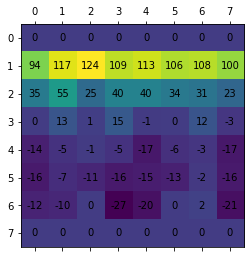

In [31]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

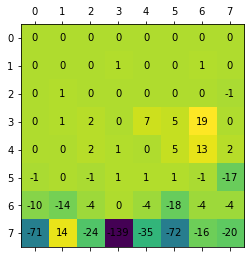

In [32]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

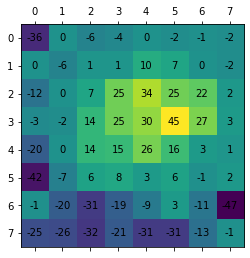

In [35]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

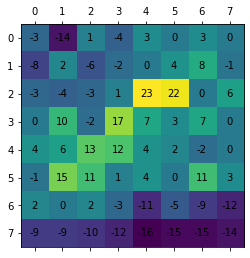

In [36]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

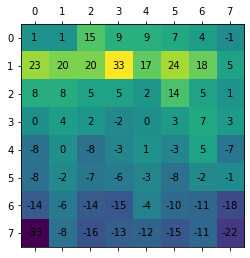

In [38]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

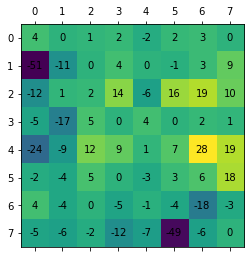

In [40]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

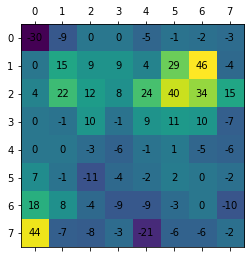

In [42]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [153]:
ww[-2], ww[-1]

(33, 44)